In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.animation as animation

from IPython.core.display import display, HTML

css = """
<style>
    .jp-Notebook .jp-Cell {
        margin-bottom: 16px !important;
    }
</style>
"""

display(HTML(css))

/tmp/ipykernel_63931/3880736236.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [5]:
df = pd.read_excel("Online Retail.xlsx")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


#### CEO report 

**Total revenue generated and sales trend** 

In [12]:
# total revenue including business expense and returns

df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
print('${:,.2f}'.format(df["TotalPrice"].sum()))

$9,747,747.93


In [96]:
# real sales per day

real_sales = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

summary = real_sales.groupby(df['InvoiceDate'].dt.date).agg(
    TotalTransactions=('InvoiceNo', 'size'),  # Count transactions
    TotalSales=('Quantity', 'sum'),          # Sum quantity sold
    TotalRevenue=('TotalPrice', 'sum')       # Sum total revenue
).reset_index()

summary['Days'] = summary['InvoiceDate'].apply(lambda x: x.toordinal())

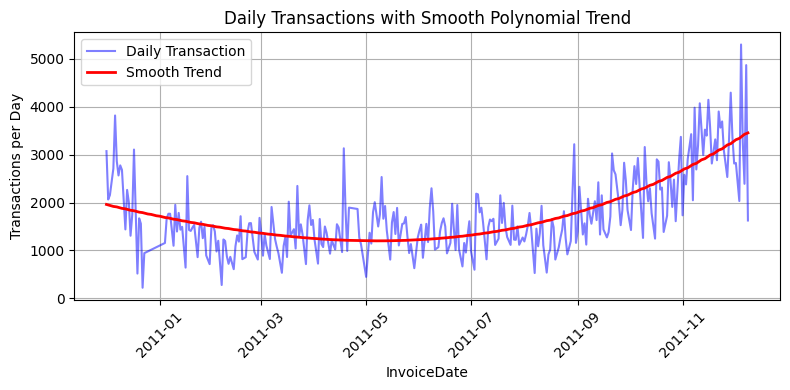

In [101]:
# plotting transaction per day

plt.figure(figsize=(8, 4))

# Fit a polynomial (e.g., degree 3 for a cubic polynomial)
degree = 3  # You can adjust the degree for more or less smoothness
trx_coef = np.polyfit(summary['Days'], summary['TotalTransactions'], degree)

# Create a smooth curve using the polynomial
smooth_days = np.linspace(summary['Days'].min(), summary['Days'].max(), 300)
smooth_trx = np.polyval(trx_coef, smooth_days)

# Convert smooth_days back to datetime for plotting
smooth_dates = [pd.Timestamp.fromordinal(int(day)) for day in smooth_days]

# Plot the original data
plt.plot(summary['InvoiceDate'], summary['TotalTransactions'], label='Daily Transaction', color='blue', alpha=0.5)

# Plot the smooth polynomial curve
plt.plot(smooth_dates, smooth_trx, label='Smooth Trend', color='red', linewidth=2)

# Add labels and legend
plt.xlabel("InvoiceDate")
plt.ylabel("Transactions per Day")
plt.title("Daily Transactions with Smooth Polynomial Trend")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

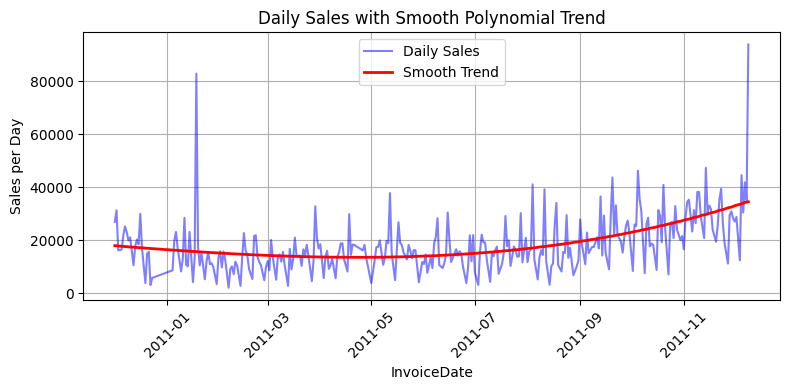

In [102]:
# plotting sales per day

plt.figure(figsize=(8, 4))

# Fit a polynomial (e.g., degree 3 for a cubic polynomial)
degree = 3  # You can adjust the degree for more or less smoothness
sales_coef = np.polyfit(summary['Days'], summary['TotalSales'], degree)

# Create a smooth curve using the polynomial
smooth_days = np.linspace(summary['Days'].min(), summary['Days'].max(), 300)
smooth_sales = np.polyval(sales_coef, smooth_days)

# Convert smooth_days back to datetime for plotting
smooth_dates = [pd.Timestamp.fromordinal(int(day)) for day in smooth_days]

# Plot the original data
plt.plot(summary['InvoiceDate'], summary['TotalSales'], label='Daily Sales', color='blue', alpha=0.5)

# Plot the smooth polynomial curve
plt.plot(smooth_dates, smooth_sales, label='Smooth Trend', color='red', linewidth=2)

# Add labels and legend
plt.xlabel("InvoiceDate")
plt.ylabel("Sales per Day")
plt.title("Daily Sales with Smooth Polynomial Trend")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

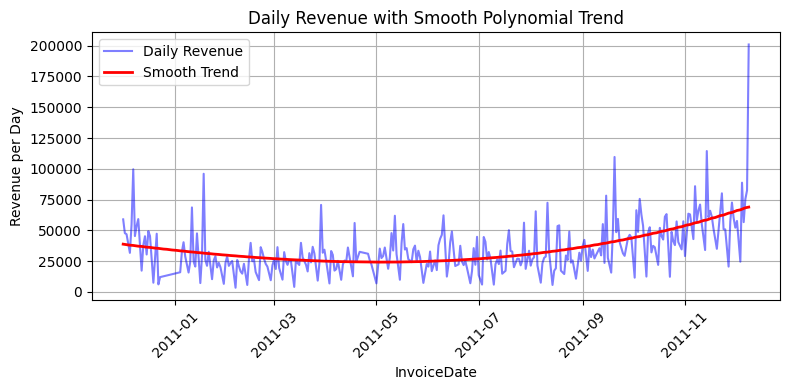

In [103]:
# plotting revenue per day

plt.figure(figsize=(8, 4))

# Fit a polynomial (e.g., degree 3 for a cubic polynomial)
degree = 3  # You can adjust the degree for more or less smoothness
revenue_coef = np.polyfit(summary['Days'], summary['TotalRevenue'], degree)

# Create a smooth curve using the polynomial
smooth_days = np.linspace(summary['Days'].min(), summary['Days'].max(), 300)
smooth_revenue = np.polyval(revenue_coef, smooth_days)

# Convert smooth_days back to datetime for plotting
smooth_dates = [pd.Timestamp.fromordinal(int(day)) for day in smooth_days]

# Plot the original data
plt.plot(summary['InvoiceDate'], summary['TotalRevenue'], label='Daily Revenue', color='blue', alpha=0.5)

# Plot the smooth polynomial curve
plt.plot(smooth_dates, smooth_revenue, label='Smooth Trend', color='red', linewidth=2)

# Add labels and legend
plt.xlabel("InvoiceDate")
plt.ylabel("Revenue per Day")
plt.title("Daily Revenue with Smooth Polynomial Trend")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

So it starts with good sales thus in turn revenue but then get's lower which is minimum and then bounce back up.
Since i am looking at real_sales data, thus there is nothing which subtracts but adds. So i can confidently hypothesis
that during this period, there are lower sales or sales of product with lower unit price with lower quantity thus at
the end earning lower total revenue by selling those product

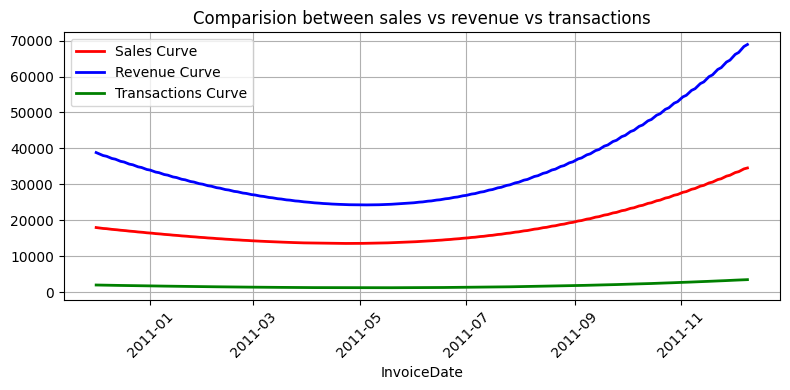

In [104]:
# comparing polynomial curvess

plt.figure(figsize=(8, 4))

plt.plot(smooth_dates, smooth_sales, label='Sales Curve', color='red', linewidth=2)
plt.plot(smooth_dates, smooth_revenue, label='Revenue Curve', color='blue', linewidth=2)
plt.plot(smooth_dates, smooth_trx, label='Transactions Curve', color='green', linewidth=2)

# Add labels and legend
plt.xlabel("InvoiceDate")
plt.title("Comparision between sales vs revenue vs transactions")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig("comparison.png")
plt.show()

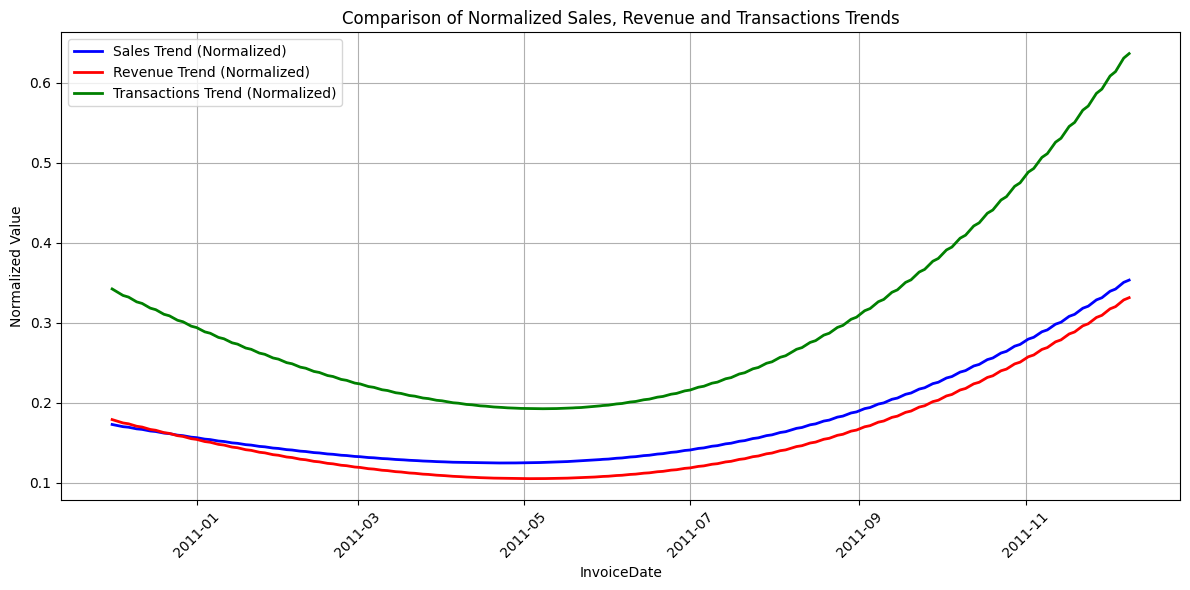

In [106]:
# normalising so having scale of sales, revenue and transaction as same

from sklearn.preprocessing import MinMaxScaler

# Normalize sales and revenue data
scaler = MinMaxScaler()
sales_normalized = scaler.fit_transform(summary[["TotalSales"]])
revenue_normalized = scaler.fit_transform(summary[["TotalRevenue"]])
transactions_normalized = scaler.fit_transform(summary[["TotalTransactions"]])

# Fit polynomials to normalized data
sales_coefficients = np.polyfit(summary['Days'], sales_normalized.flatten(), degree)
revenue_coefficients = np.polyfit(summary['Days'], revenue_normalized.flatten(), degree)
transactions_coefficients = np.polyfit(summary['Days'], transactions_normalized.flatten(), degree)

# Evaluate polynomials for smooth curves
smooth_sales_normalized = np.polyval(sales_coefficients, smooth_days)
smooth_revenue_normalized = np.polyval(revenue_coefficients, smooth_days)
smooth_trx_normalized = np.polyval(transactions_coefficients, smooth_days)

# Plot normalized curves
plt.figure(figsize=(12, 6))
plt.plot(smooth_dates, smooth_sales_normalized, label='Sales Trend (Normalized)', color='blue', linewidth=2)
plt.plot(smooth_dates, smooth_revenue_normalized, label='Revenue Trend (Normalized)', color='red', linewidth=2)
plt.plot(smooth_dates, smooth_trx_normalized, label='Transactions Trend (Normalized)', color='green', linewidth=2)

# Add labels, title, and legend
plt.xlabel("InvoiceDate")
plt.ylabel("Normalized Value")
plt.title("Comparison of Normalized Sales, Revenue and Transactions Trends")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig("comparision_normalized.png")
plt.show()

**Overal trend of curves**

- If the sales curve (blue) and revenue curve (red) follow a similar pattern (e.g., both increase or decrease at the same time), it suggests that sales and revenue are strongly correlated. This is common in retail, where higher sales directly lead to higher revenue.

- If the curves diverge significantly, it could indicate that revenue is not directly proportional to sales. This might happen due to:
  - Discounts or promotions: Higher sales volume but lower revenue due to reduced prices.
  - High-value items: Fewer sales but higher revenue due to expensive products.

  But this is real_sales subset, so curves won't diverge. As said above about correlation.

**Peaks and Troughs**

- Peaks: If both curves peak at the same time, it indicates seasonal trends or successful marketing campaigns that boosted both sales and revenue.

- Troughs: If both curves dip simultaneously, it could indicate low-demand periods (e.g., holidays, off-seasons) or operational issues (e.g., stockouts).

If i look at above plot, both the curve have peak near winter season indicating higher sales during this season. It also shows
lower sales thus revenue during summer season, i can hypothesis that during winter season there are alot of festivals and thus
people buying gifts as this is majorly gift retail store.

But after summer season, the amount of transactions pick up quickly as shown in above plot.

*Todo*: Even if amt of transactions pick up quickly the revenue and sales doesn't. Why?

**Divergent Behaviour**

- *Todo*: What does it mean by curve being below other curve?
- *Todo*: Why transaction is more curvy?, why there is divergence behaviour between transactions and rest during winter season which they call holiday seasons?